# Testing Overdispersed Count Matrix Factorization in simulated data 

In [1]:
from pCMF.misc import utils
from pCMF.models.pcmf.inferences import cavi_new, svi_new

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Experiment parameters
N = 1000 # number of observations
P = 20 # observation space dimensionality
K = 10 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0. # no ZI
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p,
                                                 eps=eps, return_all=True)

Y_train, Y_test, U_train, U_test, c_train, c_test = train_test_split(Y, U.T, clusters, test_size=0.2, random_state=42)

In [3]:
T = 60.
S = 1.

In [4]:
# Run PCA
pca_U = PCA(n_components=K).fit_transform(np.log(Y_train + 1.))
pca_tsne = TSNE(n_components=2).fit_transform(pca_U)

In [5]:
# Prior parameters
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))

In [6]:
print('Simple GaP:')
infgap = cavi_new.CoordinateAscentVI(Y_train, alpha, beta, empirical_bayes=False)
infgap.run(n_iterations=4000, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
gap_U = infgap.a[0] / infgap.a[1] # VI estimate is the mean of the variational approximation
gap_V = infgap.b[0] / infgap.b[1]
gap_S = infgap.estimate_S(infgap.p_S)
gap_tsne = TSNE(n_components=2).fit_transform(gap_U)

Simple GaP:
Iteration 42/4000. Log-likelihood: -3.189. Elapsed: 61 seconds


In [7]:
print('Simple GaP-EB:')
infgapeb = cavi_new.CoordinateAscentVI(Y_train, alpha, beta, empirical_bayes=True)
infgapeb.run(n_iterations=4000, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
gapeb_U = infgapeb.a[0] / infgapeb.a[1] # VI estimate is the mean of the variational approximation
gapeb_V = infgapeb.b[0] / infgapeb.b[1]
gapeb_S = infgapeb.estimate_S(infgapeb.p_S)
gapeb_tsne = TSNE(n_components=2).fit_transform(gapeb_U)

Simple GaP-EB:
Iteration 42/4000. Log-likelihood: -3.275. Elapsed: 61 seconds


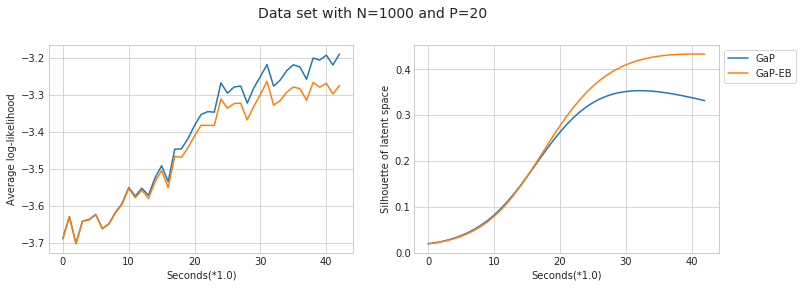

In [8]:
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(infgap.ll_time, label='GaP')
ax.plot(infgapeb.ll_time, label='GaP-EB')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds(*{0})'.format(S))

ax = plt.subplot(1, 2, 2)
ax.plot(infgap.silh_time, label='GaP')
ax.plot(infgapeb.silh_time, label='GaP-EB')
plt.ylabel('Silhouette of latent space')
plt.xlabel('Seconds(*{0})'.format(S))

plt.legend(loc='upper left', bbox_to_anchor=[1., 1.], frameon=True)
plt.suptitle('Data set with N={} and P={}'.format(N, P), fontsize=14)
plt.subplots_adjust(top=0.85)
plt.show()

In [9]:
gap_dll = utils.log_likelihood(Y_train, gap_U, gap_V, infgap.p_D, gap_S)
gapeb_dll = utils.log_likelihood(Y_train, gapeb_U, gapeb_V, infgapeb.p_D, gapeb_S)

scores = {'GaP': gap_dll, 'GaP-EB': gapeb_dll}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Full data log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Full data log-likelihood:
- GaP: -3.2
- GaP-EB: -3.27


In [10]:
gap_holl = infgap.predictive_ll(Y_test)
gapeb_holl = infgapeb.predictive_ll(Y_test)

scores = {'GaP': gap_holl, 'GaP-EB': gapeb_holl}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Held-out log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Held-out log-likelihood:
- GaP: -3.25
- GaP-EB: -3.29


In [11]:
true_silh = silhouette_score(U_train, c_train)
gap_silh = silhouette_score(gap_U, c_train)
gapeb_silh = silhouette_score(gapeb_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'GaP': gap_silh, 'GaP-EB': gapeb_silh, 'PCA': pca_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- GaP-EB: 0.434
- GaP: 0.332
- PCA: 0.275

Silhouette of true U:
0.556


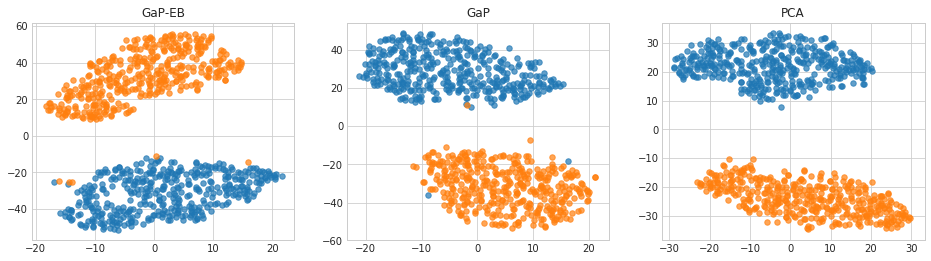

In [12]:
# Plot in decreasing silhouette order
U_list = [gap_tsne, gapeb_tsne, pca_tsne]
title_list = ['GaP', 'GaP-EB', 'PCA']

assert len(U_list) == len(title_list)

n_results = len(U_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[title_list.index(sorted_scores[i][0])][c_train==c, 0], U_list[title_list.index(sorted_scores[i][0])][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(sorted_scores[i][0])
plt.show()